In [22]:
#importing libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import cv2
import os
import PIL
%matplotlib inline


import sklearn.metrics as metrics
from keras.models import Model
from keras.layers import Flatten,Dense
#from tensorflow.keras.layers import Conv2D,MaxPooling,Flatten,Dense,Dropout
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plot
from glob import glob
import scipy as sc
from scipy import misc
from keras.models import load_model
from keras.layers import Dense, Embedding, LSTM, GRU, Flatten, Dropout, Lambda
from tensorflow.keras.preprocessing.image import load_img
from keras_preprocessing import image
import PIL
from PIL import Image
from keras.models import Sequential
from keras.optimizers import SGD

In [2]:

tf.test.gpu_device_name()

''

**IMPORTING DATA**

In [3]:
IMAGESHAPE = [224, 224, 3] 
test_set=r"D:\archive\chest_xray\chest_xray\test"
training_set=r"D:\archive\chest_xray\chest_xray\train"

In [4]:
resnet50_model=Sequential()

resnet50=tf.keras.applications.ResNet50(include_top=False,
                                                        input_shape=IMAGESHAPE,pooling='avg',classes=2,weights=None)

In [5]:
for layer in resnet50.layers:
  layer.trainable=True

In [6]:
resnet50_model.add(resnet50)
resnet50_model.add(Dense(250,activation='relu'))
resnet50_model.add(Dropout(0.5))

resnet50_model.add(Flatten())
resnet50_model.add(Dense(512,activation='relu'))
resnet50_model.add(Dense(2,activation='softmax'))

In [7]:
resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 250)               512250    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               128512    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,229,500
Trainable params: 24,176,380
No

In [8]:
classes = glob(r"D:\archive\chest_xray\chest_xray\train\*") 

In [9]:
#making the layer in one dimension 
flatten_layer = Flatten()(resnet50_model.output)
prediction = Dense(len(classes), activation='softmax')(flatten_layer)

In [10]:
final_model = Model(inputs=resnet50_model.input, outputs=prediction) 
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50_input (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 250)               512250    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               128512    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026  

In [11]:
final_model.compile( 
  loss='categorical_crossentropy',
  optimizer='SGD',
  metrics=['accuracy']
)

In [12]:
#image preprocessing and augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
testing_datagen = ImageDataGenerator(rescale =1. / 255)

In [13]:
training_set = train_datagen.flow_from_directory(r"D:\archive\chest_xray\chest_xray\train", 
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [14]:
test_set = testing_datagen.flow_from_directory(r"D:\archive\chest_xray\chest_xray\test",
                                               target_size = (224, 224),
                                               batch_size = 32,
                                               class_mode = 'categorical')

Found 624 images belonging to 2 classes.


# Rnning the model for epoochs

In [15]:
fitted_model = final_model.fit( 
  training_set,
  validation_data=test_set,
  epochs=40,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)    
)





Epoch 1/40
163/163 [==============================] - 903s 6s/step - loss: 0.4979 - accuracy: 0.7429 - val_loss: 0.9333 - val_accuracy: 0.6250
Epoch 2/40
163/163 [==============================] - 930s 6s/step - loss: 0.4037 - accuracy: 0.7429 - val_loss: 0.9533 - val_accuracy: 0.6250
Epoch 3/40
163/163 [==============================] - 904s 6s/step - loss: 0.3544 - accuracy: 0.8194 - val_loss: 0.5489 - val_accuracy: 0.6955
Epoch 4/40
163/163 [==============================] - 901s 6s/step - loss: 0.3207 - accuracy: 0.8901 - val_loss: 0.7258 - val_accuracy: 0.5224
Epoch 5/40
163/163 [==============================] - 915s 6s/step - loss: 0.3064 - accuracy: 0.8938 - val_loss: 0.4858 - val_accuracy: 0.7821
Epoch 6/40
163/163 [==============================] - 938s 6s/step - loss: 0.2843 - accuracy: 0.9053 - val_loss: 0.7260 - val_accuracy: 0.7099
Epoch 7/40
163/163 [==============================] - 922s 6s/step - loss: 0.2773 - accuracy: 0.9015 - val_loss: 0.8735 - val_accuracy: 0.3814

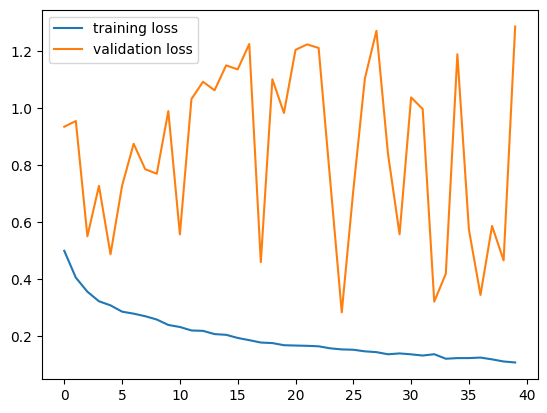

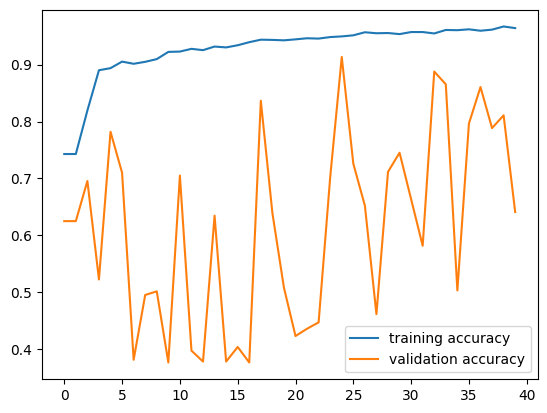

In [16]:
plot.plot(fitted_model.history['loss'], label='training loss') #Plotting the accuracies
plot.plot(fitted_model.history['val_loss'], label='validation loss')
plot.legend()
plot.show()

plot.plot(fitted_model.history['accuracy'], label='training accuracy')
plot.plot(fitted_model.history['val_accuracy'], label='validation accuracy')
plot.legend()
plot.show()

In [17]:
final_model.save('resnet50.h5')

In [18]:
model=load_model('resnet50.h5') #Loading our model
img=image.load_img(r"D:\archive\chest_xray\chest_xray\train\PNEUMONIA\person1_bacteria_1.jpeg",target_size=(224,224))
imagee=image.img_to_array(img) #Converting the X-Ray into pixels
imagee=np.expand_dims(imagee, axis=0)
img_data=preprocess_input(imagee)
prediction=model.predict(img_data)
if prediction[0][0]>prediction[0][1]:  #Printing the prediction of model.
    print('Person is safe.')
else:
    print('Person is affected with Pneumonia.')
print(f'Predictions: {prediction}')

1/1 [==============================] - 0s 369ms/step
Person is affected with Pneumonia.
Predictions: [[0. 1.]]


In [19]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
   r"D:\archive\chest_xray\chest_xray\test", 
     target_size=(224,224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 624 images belonging to 2 classes.
20/20 [==============================] - 45s 2s/step


In [20]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [23]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.94      0.13      0.23       234
   PNEUMONIA       0.66      0.99      0.79       390

    accuracy                           0.67       624
   macro avg       0.80      0.56      0.51       624
weighted avg       0.76      0.67      0.58       624

